# Imports and Paths

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numba as nb
import time
%load_ext line_profiler

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [23]:
from palettable.cartocolors.qualitative import Prism_8
prism = Prism_8.mpl_colors
blue = prism[1]
green = prism[3]
purple = prism[0]
red = prism[7]
orange = prism[6]
yellow = prism[5]
gray = '#303039'
#importing plotting parameters
#style = '/home/gleung/scripts/styles/bee-paperlight.mplstyle'
style = '/home/gleung/scripts/styles/bee-presentationtransparent.mplstyle'
plt.style.use(style)

import matplotlib.font_manager as font_manager
from matplotlib import rcParams

# Add every font at the specified location
font_dir = ['/home/gleung/scripts/futura']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
rcParams['font.family'] = 'Futura'

bg = '#4A4A55'
lcol='white'

#lcol = 'black'

In [9]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def add_latlon(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

In [11]:
dataPath = '/moonbow/gleung/satlcc/GFC_2021_v1.9/'
figPath = '/moonbow/gleung/satlcc-figures/presentation/'
anaPath = '/moonbow/gleung/satlcc/GFC_processing/'

# Testing Functions

## Read GFC Data

Since each tile is very large, will process each tile at 30m resolution into 1km resolution first before concatenating tiles.

In [5]:
lat = 0
lon = 100

var = 'treecover2000'
path = f"{dataPath}{var}/Hansen_GFC-2021-v1.9_{var}_{str(lat).zfill(2)}N_{str(lon).zfill(3)}E.tif"
treecover = np.array(Image.open(path))[::-1,::]

'''var = 'lossyear'
path = f"{dataPath}{var}/Hansen_GFC-2021-v1.9_{var}_{str(lat).zfill(2)}N_{str(lon).zfill(3)}E.tif"
lossyear = np.array(Image.open(path))[::-1,::]'''

'var = \'lossyear\'\npath = f"{dataPath}{var}/Hansen_GFC-2021-v1.9_{var}_{str(lat).zfill(2)}N_{str(lon).zfill(3)}E.tif"\nlossyear = np.array(Image.open(path))[::-1,::]'

In [6]:
#File name refers to top left corner of tile
lats = np.linspace(lat-10, lat, lossyear.shape[0]+1)[1:]
lons = np.linspace(lon, lon+10, lossyear.shape[1]+1)[:-1]

## Define Yearly Tree Cover

In [ ]:
ave_res = 32 #32 arcseconds is approximately 1km
n = 125 #number of chunks to subset (~number of km x number of km box)

treecover = treecover[-ave_res*n:,-ave_res*n:]
lossyear = lossyear[-ave_res*n:,-ave_res*n:]

In [ ]:
print(lats)
print(lons)

In [ ]:
fig, axes = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,5),
                        subplot_kw={'projection':ccrs.PlateCarree()})

nplot = 20

treecover_ = treecover[-nplot*ave_res:,-nplot*ave_res:]
lossyear_ = lossyear[-nplot*ave_res:,-nplot*ave_res:]

c = axes[0].pcolormesh(lons[-nplot*ave_res:],
                       lats[-nplot*ave_res:],
                       treecover_, cmap='Greens',
                  vmin=0, vmax=100)
plt.colorbar(c,ax=axes[0],orientation='horizontal',label='Forest Cover Fraction in 2000')
axes[0].set_title('(a)')

c = axes[1].pcolormesh(lons[-nplot*ave_res:],
                       lats[-nplot*ave_res:],
                       np.where(treecover_>=75,1,0), cmap='Greens',
                  vmin=0, vmax=1)
plt.colorbar(c,ax=axes[1],orientation='horizontal',label='Binarized Forest Cover in 2000')
axes[1].set_title('(b)')

c = axes[2].pcolormesh(lons[-nplot*ave_res:],
                       lats[-nplot*ave_res:],
                       np.where(lossyear_!=0,lossyear_+2000,np.nan))
plt.colorbar(c,ax=axes[2],orientation='horizontal',label='Year of Forest Loss')
axes[2].set_title('(c)')

for ax in axes:
    add_latlon(ax)
    #ax.set_xlim(100,110)
    #ax.set_ylim(-10,0)
    #ax.coastlines()
        
plt.savefig(f"{figPath}sample_rawdata.png",dpi=300)
plt.show()

In [ ]:
def binarize_annual_forest(treecover,lossyear,forest_thresh=75):
    #binarizing forest cover
    forest_00 = np.where(treecover>forest_thresh,1,0)
    
    forest_all = np.zeros((forest_00.shape[0],forest_00.shape[1],21))
    forest_all[:,:,0] = forest_00[:,:]
    
    for yr in range(1,21):
        forest_all[:,:,yr] = np.where((lossyear<=yr) & (lossyear!=0),0,forest_00)
    
    return(forest_all)

In [ ]:
%lprun -f binarize_annual_forest binarize_annual_forest(treecover,lossyear,forest_thresh)

In [7]:
@nb.njit
def binarize_annual_forest(treecover,lossyear,forest_thresh=75,yrs = 21):
    #binarizing forest cover
    forest_00 = np.where(treecover>forest_thresh,1,0)
    
    forest_all = np.zeros((forest_00.shape[0],forest_00.shape[1],yrs))
    
    for yr in range(forest_all.shape[2]):
        forest_all[:,:,yr] = forest_00[:,:] #initially set forest cover for all years to be the same as in year 2000
    
    for i in range(forest_all.shape[0]):
        for j in range(forest_all.shape[1]):
            if forest_00[i,j]!=0: #if not forested to begin with, then no need to look at it
                loss_yr = lossyear[i,j]
                for yr in range(loss_yr,forest_all.shape[2]): #replace all forest cover values in years after loss year with 0
                    forest_all[i,j,yr] = 0

    return(forest_all)

In [ ]:
%%time

forest_thresh=75

forest_all=binarize_annual_forest(treecover,lossyear,forest_thresh)

In [ ]:
nplot = 20 #number of chunks to plot (number of km x number of km box)

forest_sub = forest_all[-nplot*ave_res:,-nplot*ave_res:,:]

fig, axes = plt.subplots(1,5,sharex=True,sharey=True,figsize=(22,5),
                        subplot_kw={'projection':ccrs.PlateCarree()})
axes = axes.flatten()

for ax,yr in zip(axes,[0,5,10,15,20]):
    ax.pcolormesh(lons[-nplot*ave_res:],
                  lats[-nplot*ave_res:],
                  forest_sub[:,:,yr], 
                  cmap='Greens')
        
    ax.set_title(f"20{str(yr).zfill(2)}",loc='center')
    
    add_latlon(ax)
    
plt.savefig(f"{figPath}sample_forestcover30m_binarizedyearly.png",dpi=300)
plt.show()

## Resample to 1km Resolution

In [ ]:
#averaging resolution of 32 --> 1km resolution
#averaging resolution of 160 --> 5km resolution

In [8]:
@nb.njit
def coarsen_forest(forest,ave_res=32,yrs=21):
    n = int(forest.shape[0]/ave_res)
    forest_coarse = np.zeros((n,n,yrs))
    
    for yr in range(yrs):
        for i in range(n):
            for j in range(n):
                forest_coarse[i,j,yr] = forest[ave_res*i:ave_res*(i+1),ave_res*j:ave_res*(j+1),yr].sum()/(ave_res*ave_res)
                
    return(forest_coarse)

In [ ]:
%%time

forest_coarse = coarsen_forest(forest_all,ave_res=160)

In [ ]:
nplot = 20 #number of chunks to plot (number of km x number of km box)
forest_coarse_sub = forest_coarse[-nplot:,-nplot:,:]

fig, axes = plt.subplots(1,5,sharex=True,sharey=True,figsize=(22,5),
                        subplot_kw={'projection':ccrs.PlateCarree()})
axes = axes.flatten()

for ax,yr in zip(axes,[0,5,10,15,20]):
    c = ax.pcolormesh(lons[-nplot*ave_res::ave_res],
                  lats[-nplot*ave_res::ave_res],
                  forest_coarse_sub[:,:,yr],vmin = 0, vmax=1, cmap='Greens')
    
    ax.set_title(f"20{str(yr).zfill(2)}",loc='center')
    add_latlon(ax)
    
cax = fig.add_axes([axes[0].get_position().x0,
                    axes[1].get_position().y0-0.145, 
                   axes[-1].get_position().x1 - axes[0].get_position().x0,
                           0.065])
cbar = plt.colorbar(c,cax=cax, orientation='horizontal', 
                    label = 'Forest Cover Fraction'
                   )     
    
plt.savefig(f"{figPath}sample_forestcover5km.png",dpi=300)
plt.show()

# Run on One Tile

In [ ]:
lat = 10
lon = 110
forest_thresh=75

starttime=time.time()
for lat in [0,10,20,30]:
    for lon in [90,100,110,120,130]:
        print(lat,lon)
        
        var = 'treecover2000'
        path = f"{dataPath}{var}/Hansen_GFC-2021-v1.9_{var}_{str(lat).zfill(2)}N_{str(lon).zfill(3)}E.tif"
        treecover = np.array(Image.open(path))[::-1,::]

        var = 'lossyear'
        path = f"{dataPath}{var}/Hansen_GFC-2021-v1.9_{var}_{str(lat).zfill(2)}N_{str(lon).zfill(3)}E.tif"
        lossyear = np.array(Image.open(path))[::-1,::]

        ave_res = 160 #32 arcseconds is approximately 1km
        n = 5 #number of chunks to subset (~number of km x number of km box)

        forest = []
        for i in range(0,int(treecover.shape[0]/(ave_res*n))):
            forest_rows = []
            for j in range(0,int(treecover.shape[1]/(ave_res*n))):
                treecover_ = treecover[i*ave_res*n:(i+1)*ave_res*n,j*ave_res*n:(j+1)*ave_res*n]
                lossyear_ = lossyear[i*ave_res*n:(i+1)*ave_res*n,j*ave_res*n:(j+1)*ave_res*n]

                forest_all=binarize_annual_forest(treecover_,lossyear_,forest_thresh)
                forest_coarse = coarsen_forest(forest_all,ave_res)

                forest_rows.append(forest_coarse)

            forest.append(np.concatenate(forest_rows,axis=1))
        print('saving')
        forest = np.concatenate(forest,axis=0)
        np.save(f"{anaPath}forestcover5km_{str(lat).zfill(2)}N_{str(lon).zfill(3)}E.pkl", forest)

        loss = -np.diff(forest,axis=-1)
        np.save(f"{anaPath}forestloss5km_{str(lat).zfill(2)}N_{str(lon).zfill(3)}E.pkl", loss)
        
        print(time.time()-starttime)

0 90
saving
780.4874956607819
0 100
saving
1580.3330523967743
0 110
saving
2415.345248937607
0 120
saving
3226.871260404587
0 130
saving
4013.636379957199
10 90


In [ ]:
lats = np.linspace(lat-10, lat, forest.shape[0]+1)[1:]
lons = np.linspace(lon, lon+10, forest.shape[1]+1)[:-1]

fig, axes = plt.subplots(1,5,sharex=True,sharey=True,figsize=(15,5),
                        subplot_kw={'projection':ccrs.PlateCarree()})
axes = axes.flatten()

for ax,yr in zip(axes,[0,5,10,15,20]):
    c = ax.contourf(lons, lats,
                  forest[:,:,yr],
                    levels = np.linspace(0,1,11),
                    cmap='Greens')
    
    ax.coastlines()
    add_latlon(ax)
    
    ax.set_title(f"20{str(yr).zfill(2)}",loc='center')
    
ax.set_xlim(110,120)
ax.set_ylim(0,10)

cax = fig.add_axes([axes[0].get_position().x0,
                    axes[1].get_position().y0-0.1125, 
                    axes[-1].get_position().x1 - axes[0].get_position().x0,
                    0.035])
cbar = plt.colorbar(c,cax=cax, orientation='horizontal', 
                    label = 'Forest Cover Fraction'
                   ) 

plt.savefig(f"{figPath}sample_forestcover5km_tile.png",dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
lats = np.linspace(lat-10, lat, forest.shape[0]+1)[1:]
lons = np.linspace(lon, lon+10, forest.shape[1]+1)[:-1]

fig, axes = plt.subplots(1,4,sharex=True,sharey=True,figsize=(13,5),
                        subplot_kw={'projection':ccrs.PlateCarree()})
axes = axes.flatten()

for ax,yr in zip(axes,[4,9,14,19]):
    c = ax.contourf(lons, lats,
                  loss[:,:,yr],
                    levels = np.linspace(0,0.5,11),
                    extend='max',
                    cmap='Reds')
    
    ax.coastlines()
    add_latlon(ax)
    
    ax.set_title(f"20{str(yr+1).zfill(2)}",loc='center')
    
ax.set_xlim(110,120)
ax.set_ylim(0,10)

cax = fig.add_axes([axes[0].get_position().x0,
                    axes[1].get_position().y0-0.1125, 
                    axes[-1].get_position().x1-axes[0].get_position().x0,
                    0.035])
cbar = plt.colorbar(c,cax=cax, orientation='horizontal', 
                    label = 'Forest Loss Fraction'
                   ) 

plt.savefig(f"{figPath}sample_forestloss5km_tile.png",dpi=300,bbox_inches='tight')
plt.show()

In [15]:
forest = np.load(f"{anaPath}forestcover1km_{str(0).zfill(2)}N_{str(120).zfill(3)}E.pkl.npy")

# Full Map

In [16]:
fig, axes = plt.subplots(1,5,sharex=True,sharey=True,figsize=(18,8),
                        subplot_kw={'projection':ccrs.PlateCarree()})
axes = axes.flatten()

for lat in [0,10,20,30]:
    for lon in [90,100,110,120,130]:
        print(lat,lon)
        lats = np.linspace(lat-10, lat, forest.shape[0]+1)[1:]
        lons = np.linspace(lon, lon+10, forest.shape[1]+1)[:-1]
        
        forest = np.load(f"{anaPath}forestcover1km_{str(lat).zfill(2)}N_{str(lon).zfill(3)}E.pkl.npy")

        for ax,yr in zip(axes,[0,5,10,15,20]):
            c = ax.contourf(lons, lats,
                          forest[:,:,yr],
                            levels = np.linspace(0,1,11),
                            cmap='Greens')

for ax,yr in zip(axes,[0,5,10,15,20]):
    ax.coastlines()
    add_latlon(ax)

    ax.set_title(f"20{str(yr).zfill(2)}",loc='center')

cax = fig.add_axes([axes[0].get_position().x0,
                    axes[1].get_position().y0-0.1125, 
                    axes[-1].get_position().x1 - axes[0].get_position().x0,
                    0.035])
cbar = plt.colorbar(c,cax=cax, orientation='horizontal', 
                    label = 'Forest Cover Fraction'
                   ) 

plt.savefig(f"{figPath}full_forestcover1km_tile.png",dpi=300,bbox_inches='tight')
plt.show()

0 90
0 100
0 110
0 120
0 130
10 90
10 100
10 110



KeyboardInterrupt



Error in callback <function flush_figures at 0x7f39490a7c70> (for post_execute):



KeyboardInterrupt



0 90
0 100
0 110
0 120
0 130
10 90
10 100
10 110
10 120
10 130
20 90
20 100
20 110
20 120
20 130
30 90
30 100
30 110
30 120
30 130


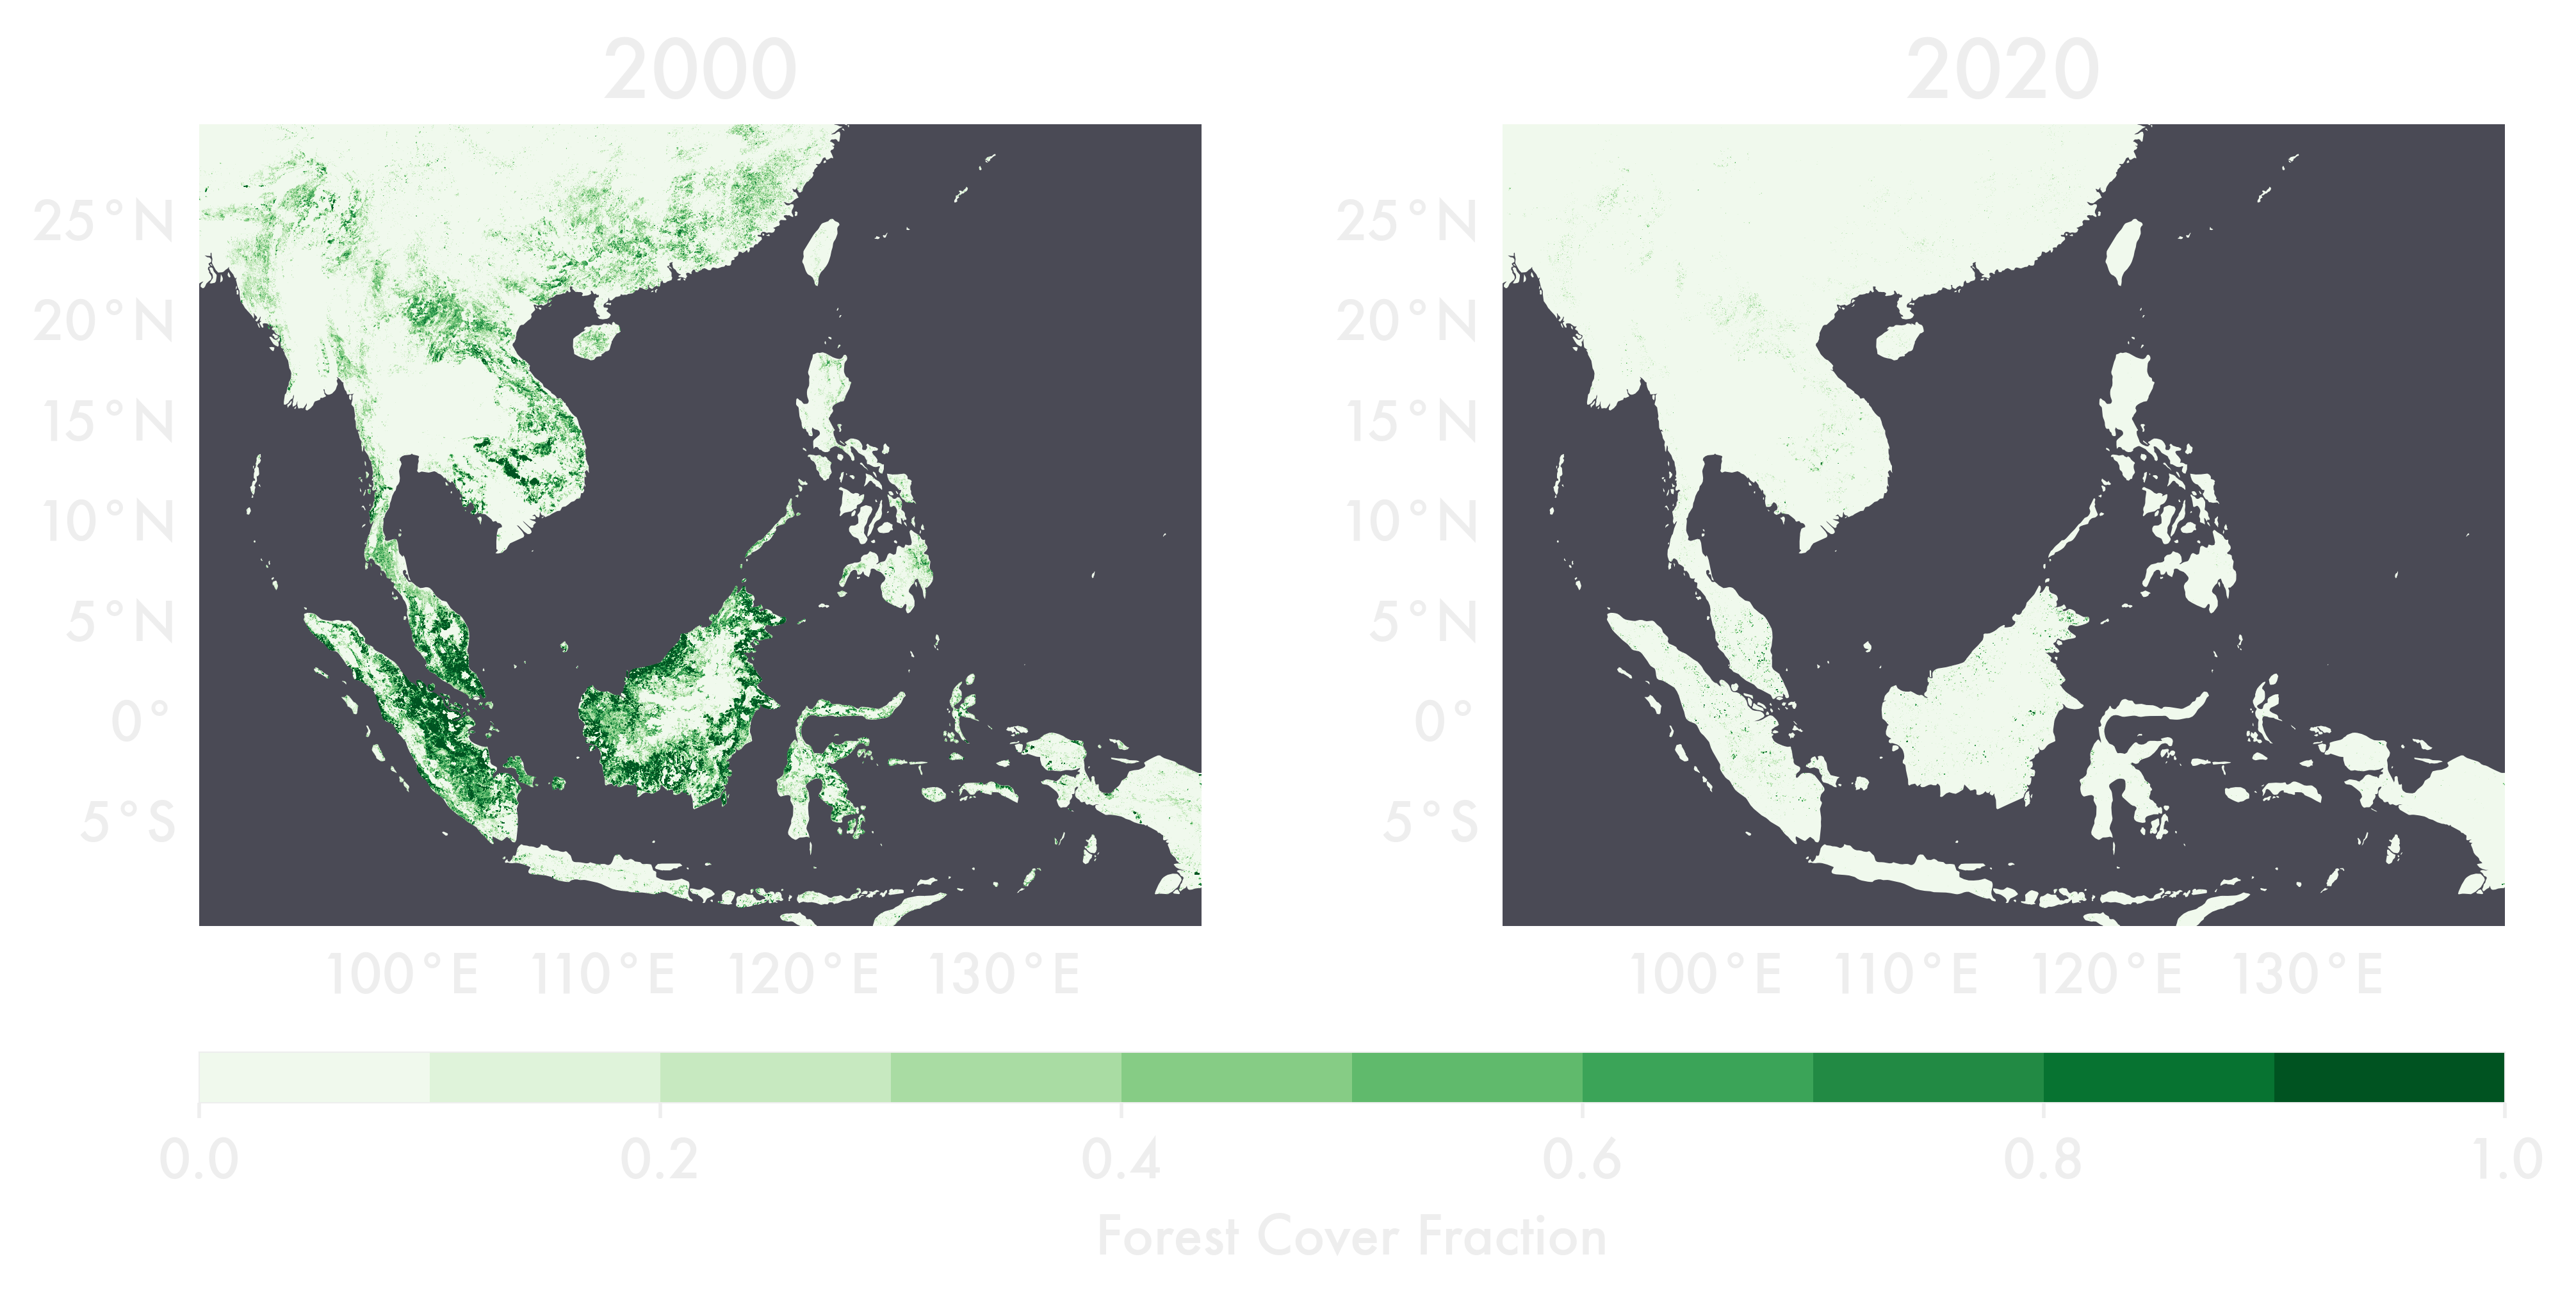

In [30]:
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,4.5),
                        subplot_kw={'projection':ccrs.PlateCarree()})
axes = axes.flatten()

for lat in [0,10,20,30]:
    for lon in [90,100,110,120,130]:
        print(lat,lon)
        lats = np.linspace(lat-10, lat, forest.shape[0]+1)[1:]
        lons = np.linspace(lon, lon+10, forest.shape[1]+1)[:-1]
        
        forest = np.load(f"{anaPath}forestcover1km_{str(lat).zfill(2)}N_{str(lon).zfill(3)}E.pkl.npy")

        for ax,yr in zip(axes,[0,20]):
            c = ax.contourf(lons, lats,
                          forest[:,:,yr],
                            levels = np.linspace(0,1,11),
                            cmap='Greens')

for ax,yr in zip(axes,[0,20]):
    #ax.coastlines()
    add_latlon(ax)
    ax.add_feature(cfeature.NaturalEarthFeature('physical',
                                                'ocean', 
                                                '50m', 
                                                edgecolor=None, 
                                                facecolor=bg))

    ax.set_title(f"20{str(yr).zfill(2)}",loc='center')
    ax.axis('off')

cax = fig.add_axes([axes[0].get_position().x0,
                    axes[1].get_position().y0-0.1225, 
                    axes[-1].get_position().x1 - axes[0].get_position().x0,
                    0.035])
cbar = plt.colorbar(c,cax=cax, orientation='horizontal', 
                    label = 'Forest Cover Fraction'
                   ) 

plt.savefig(f"{figPath}full_forestcover1km_tile-present.png",dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
print(figPath)

In [18]:
import cartopy.feature as cfeature

In [ ]:
fig, axes = plt.subplots(1,4,sharex=True,sharey=True,figsize=(15,8),
                        subplot_kw={'projection':ccrs.PlateCarree()})
axes = axes.flatten()

for lat in [0,10,20,30]:
    for lon in [90,100,110,120,130]:
        print(lat,lon)
        lats = np.linspace(lat-10, lat, forest.shape[0]+1)[1:]
        lons = np.linspace(lon, lon+10, forest.shape[1]+1)[:-1]
        
        loss = np.load(f"{anaPath}forestloss1km_{str(lat).zfill(2)}N_{str(lon).zfill(3)}E.pkl.npy")

        for ax,yr in zip(axes,[4,9,14,19]):
            c = ax.contourf(lons, lats,
                          loss[:,:,yr],
                            levels = np.linspace(0,0.5,11),
                            extend='max',
                            cmap='Reds')

for ax,yr in zip(axes,[4,9,14,19]):
    ax.coastlines()
    add_latlon(ax)

    ax.set_title(f"20{str(yr+1).zfill(2)}",loc='center')

cax = fig.add_axes([axes[0].get_position().x0,
                    axes[1].get_position().y0-0.1125, 
                    axes[-1].get_position().x1 - axes[0].get_position().x0,
                    0.035])
cbar = plt.colorbar(c,cax=cax, orientation='horizontal', 
                    label = 'Forest Loss Fraction'
                   ) 

plt.savefig(f"{figPath}full_forestloss1km_tile.png",dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
print(sorted(os.listdir(f"{anaPath}")))

In [ ]:
print(anaPath)

In [ ]:
for lat in [0,10,20,30]:
    #for lon in [90,100,110,120,130]:
    print(lat,lon)
    
    lats = np.linspace(lat-10, lat, forest.shape[0]+1)[1:]
    lons = np.linspace(lon, lon+10, forest.shape[1]+1)[:-1]

    print(lats)
    print(np.diff(lats))

In [ ]:
lats = np.linspace(-10, 30, forest.shape[0]*4+1)[1:]
lons = np.linspace(90, 140, forest.shape[1]*5+1)[:-1]

print(lats)
print(lons)

In [ ]:
print(forest.shape)